## 0. Download dataset
**Note:** If you can't download using gdown due to limited number of downloads, please download it manually and upload it to your drive, then copy it from the drive to colab.
```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

## 2. Load dataset

In [3]:
dataset_path = '/content/drive/Othercomputers/My Laptop/Advanced/Exercises/230917 - XGBoost Solution - TA_Khoa/Problem3.csv'
data_df = pd.read_csv(dataset_path)
data_df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,4.468204,26.2,94.3,1.808289,8.2,51,6.7,False,0.000000
1,7,4,oct,tue,4.517431,35.4,669.1,2.041220,18.0,33,0.9,False,0.000000
2,7,4,oct,sat,4.517431,43.7,686.9,2.041220,14.6,33,1.3,False,0.000000
3,8,6,mar,fri,4.529368,33.3,77.5,2.302585,8.3,97,4.0,True,0.000000
4,8,6,mar,sun,4.503137,51.3,102.2,2.360854,11.4,99,1.8,False,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,4,3,aug,sun,4.414010,56.7,665.6,1.064711,27.8,32,2.7,False,2.006871
506,2,4,aug,sun,4.414010,56.7,665.6,1.064711,21.9,71,5.8,False,4.012592
507,7,4,aug,sun,4.414010,56.7,665.6,1.064711,21.2,70,6.7,False,2.498152
508,1,4,aug,sat,4.558079,146.0,614.7,2.509599,25.6,42,4.0,False,0.000000


In [4]:
data_df.shape

(510, 13)

In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       510 non-null    int64  
 1   Y       510 non-null    int64  
 2   month   510 non-null    object 
 3   day     510 non-null    object 
 4   FFMC    510 non-null    float64
 5   DMC     510 non-null    float64
 6   DC      510 non-null    float64
 7   ISI     510 non-null    float64
 8   temp    510 non-null    float64
 9   RH      510 non-null    int64  
 10  wind    510 non-null    float64
 11  rain    510 non-null    bool   
 12  area    510 non-null    float64
dtypes: bool(1), float64(7), int64(3), object(2)
memory usage: 48.4+ KB


## 3. Dealing with categorical data


### 3.1. Check categorical data

In [6]:
categorical_cols = data_df.select_dtypes(include=['object', 'bool']).columns.to_list()
categorical_cols

['month', 'day', 'rain']

In [7]:
for col_name in categorical_cols:
    n_categories = data_df[col_name].nunique()
    print(f'Number of categories in {col_name}: {n_categories}')

Number of categories in month: 12
Number of categories in day: 7
Number of categories in rain: 2


### 3.2. Encode Categorical Data

In [8]:
ordinal_encoder = OrdinalEncoder()
encoded_categorical_cols = ordinal_encoder.fit_transform(data_df[categorical_cols])

encoded_categorical_df = pd.DataFrame(
  encoded_categorical_cols ,
  columns = categorical_cols
)

numerical_df = data_df.drop(categorical_cols , axis =1)
encoded_df = pd.concat([numerical_df, encoded_categorical_df ] , axis =1)

In [9]:
encoded_df

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,area,month,day,rain
0,7,5,4.468204,26.2,94.3,1.808289,8.2,51,6.7,0.000000,7.0,0.0,0.0
1,7,4,4.517431,35.4,669.1,2.041220,18.0,33,0.9,0.000000,10.0,5.0,0.0
2,7,4,4.517431,43.7,686.9,2.041220,14.6,33,1.3,0.000000,10.0,2.0,0.0
3,8,6,4.529368,33.3,77.5,2.302585,8.3,97,4.0,0.000000,7.0,0.0,1.0
4,8,6,4.503137,51.3,102.2,2.360854,11.4,99,1.8,0.000000,7.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,4,3,4.414010,56.7,665.6,1.064711,27.8,32,2.7,2.006871,1.0,3.0,0.0
506,2,4,4.414010,56.7,665.6,1.064711,21.9,71,5.8,4.012592,1.0,3.0,0.0
507,7,4,4.414010,56.7,665.6,1.064711,21.2,70,6.7,2.498152,1.0,3.0,0.0
508,1,4,4.558079,146.0,614.7,2.509599,25.6,42,4.0,0.000000,1.0,2.0,0.0


## 4. Train test split

In [10]:
X = encoded_df.drop(columns=['area'])
y = encoded_df['area']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [12]:
print(f'Number of training samples: {X_train.shape[0]}')
print(f'Number of val samples: {X_test.shape[0]}')

Number of training samples: 357
Number of val samples: 153


## 5. Training

In [13]:
xg_reg = xgb.XGBRegressor(seed=7, learning_rate=0.01, n_estimators=102, max_depth=3)

In [14]:
xg_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=102, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## 6. Evaluation

In [15]:
preds = xg_reg.predict(X_test)

In [16]:
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)

print('Evaluation results on test set:')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

Evaluation results on test set:
Mean Absolute Error: 1.1484401341167767
Mean Squared Error: 1.8845074196256495


In [17]:
preds # 0.85726804

array([1.0842953 , 1.1191528 , 0.8486002 , 2.0224624 , 1.2788543 ,
       1.2250828 , 1.3104433 , 1.2034497 , 1.049782  , 1.1554059 ,
       1.199015  , 1.1923933 , 1.0917312 , 1.0008674 , 1.0240752 ,
       1.2901965 , 0.8638762 , 1.0937988 , 0.99773127, 1.1649472 ,
       1.1940109 , 1.3383218 , 1.0232271 , 1.2133856 , 1.1919765 ,
       1.1378535 , 1.0194002 , 1.0811108 , 1.184996  , 1.3049333 ,
       1.1830077 , 1.3067408 , 1.1667005 , 1.3425988 , 1.3937967 ,
       1.0007488 , 1.208391  , 1.2034497 , 1.0767705 , 1.2819778 ,
       1.1705064 , 1.2479149 , 0.92552763, 1.8053247 , 1.0428364 ,
       1.0156305 , 1.1495866 , 1.1290253 , 1.026823  , 1.174421  ,
       1.0199474 , 1.1087017 , 1.3341991 , 1.292637  , 1.3510199 ,
       1.0883718 , 0.9601164 , 1.2643764 , 1.117172  , 1.3104433 ,
       1.1043178 , 1.1449616 , 1.0224761 , 1.1609155 , 1.2342656 ,
       1.1611481 , 1.4087317 , 1.0568017 , 0.9867578 , 1.0175698 ,
       0.9044889 , 1.1912946 , 1.3288516 , 1.2732868 , 1.06959

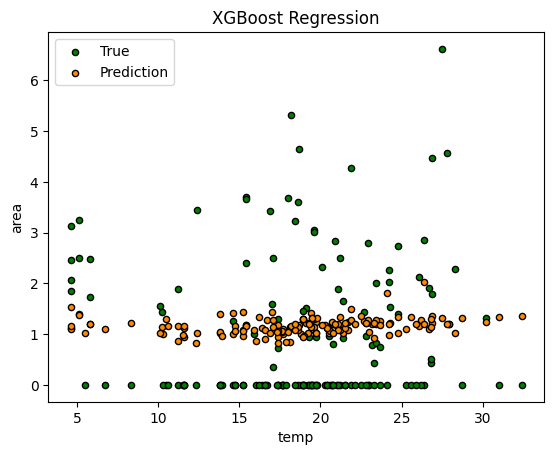

In [18]:
plt.figure()
plt.scatter(X_test['temp'], y_test, s=20, edgecolor="black", c="green", label="True")
plt.scatter(X_test['temp'], preds, s=20, edgecolor="black", c="darkorange", label="Prediction")
plt.xlabel("temp")
plt.ylabel("area")
plt.title("XGBoost Regression")
plt.legend()
plt.show()